
--------------------------------------------------------------------

Simulated 5.0 min PPG @ 100 Hz, mean HR ~70.0 bpm


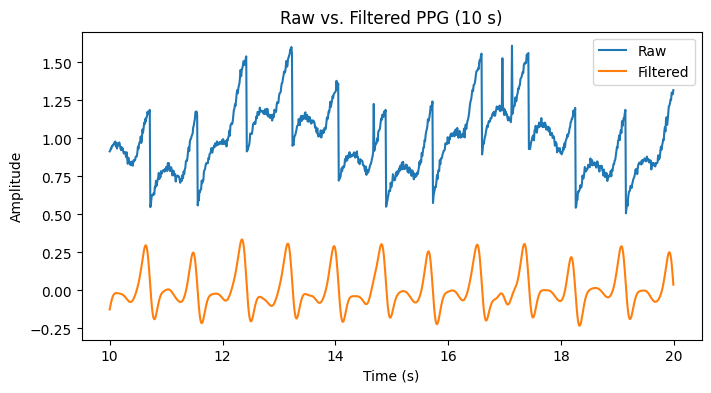


--------------------------------------------------------------------



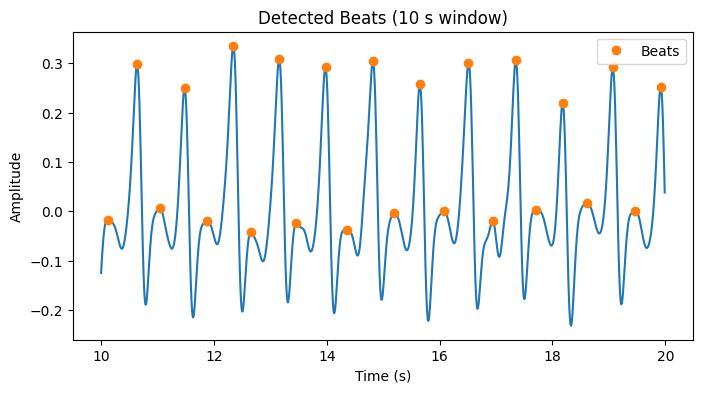


--------------------------------------------------------------------



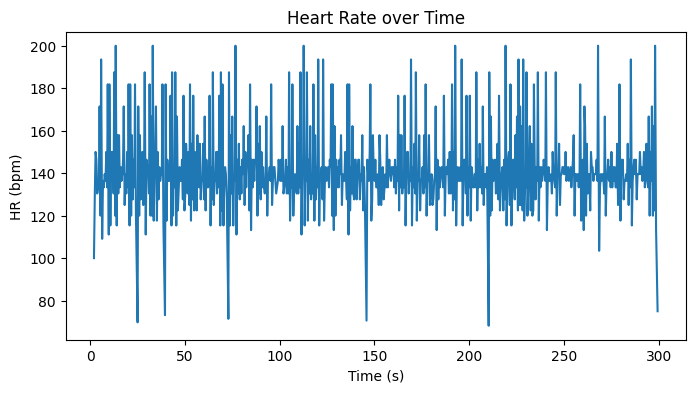


--------------------------------------------------------------------

Beats detected: 690 | Mean HR: 141.5 bpm
SDNN: 64.9 ms | RMSSD: 108.1 ms


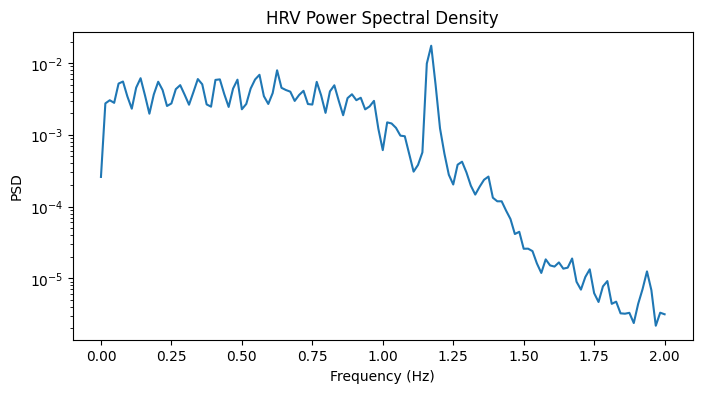

LF power: 0.0004 | HF power: 0.0009 | LF/HF: 0.45

--------------------------------------------------------------------



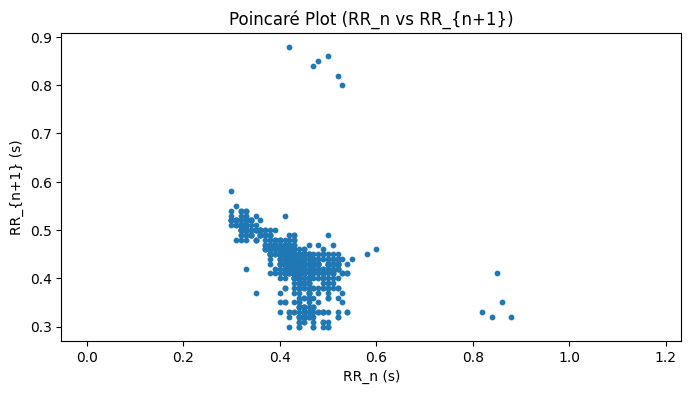


--------------------------------------------------------------------

Saved: ppg_timeseries.csv, ppg_metrics.json


In [ ]:
# Wearable PPG Signal Processing: HR & HRV (Synthetic Data)
# Paste this single cell into Google Colab and Run All.

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks, welch, detrend
from scipy.interpolate import interp1d
import pandas as pd
from dataclasses import dataclass
import json
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# -----------------------------
# Config & simulation
# -----------------------------
np.random.seed(42)
plt.rcParams['figure.figsize'] = (8, 4)
print("")
print("--------------------------------------------------------------------")
print("")

@dataclass
class PPGConfig:
    fs: int = 100          # sampling rate (Hz)
    duration_s: int = 300  # 5 minutes
    mean_hr_bpm: float = 70.0
    hr_std_bpm: float = 4.0
    resp_hz: float = 0.25  # ~15 breaths/min baseline wander
    motion_amp: float = 0.02
    white_noise_std: float = 0.015

cfg = PPGConfig()
t = np.arange(0, cfg.duration_s, 1/cfg.fs)

def simulate_ppg(t, cfg: PPGConfig):
    mean_rr = 60.0 / cfg.mean_hr_bpm
    # jitter around mean RR; keep simple and stable
    rr_sigma = (60.0/cfg.mean_hr_bpm - 60.0/(cfg.mean_hr_bpm + cfg.hr_std_bpm)) / 2.0
    rr_sigma = max(rr_sigma, 0.02)  # floor for variability
    rr = np.random.normal(loc=mean_rr, scale=rr_sigma, size=int(cfg.duration_s * cfg.mean_hr_bpm/60)+50)
    rr = np.clip(rr, 0.5*mean_rr, 1.5*mean_rr)
    beat_times = np.cumsum(rr)
    beat_times = beat_times[beat_times < t[-1] - 1/cfg.fs]

    # pulse kernel (fast rise, slow decay)
    kernel_len = int(1.2 * cfg.fs)
    xk = np.linspace(0, 1.2, kernel_len)
    kernel = (xk**2) * np.exp(-3*xk)
    kernel /= kernel.max()

    ppg = np.zeros_like(t)
    for bt in beat_times:
        idx = int(bt * cfg.fs)
        if idx + kernel_len < len(ppg):
            ppg[idx:idx+kernel_len] += kernel

    baseline = 0.2 * np.sin(2*np.pi*cfg.resp_hz*t)
    drift = signal.savgol_filter(np.random.randn(len(t))*cfg.motion_amp, 501, 3)
    spikes = np.zeros_like(t)
    spike_idx = np.random.choice(len(t), size=len(t)//500, replace=False)
    spikes[spike_idx] = np.random.uniform(0.2, 0.5, size=spike_idx.size)
    noise = np.random.randn(len(t)) * cfg.white_noise_std

    raw = ppg + baseline + drift + spikes + noise
    return raw, ppg, beat_times

raw, clean_ref, true_beats_s = simulate_ppg(t, cfg)
print(f"Simulated {cfg.duration_s/60:.1f} min PPG @ {cfg.fs} Hz, mean HR ~{cfg.mean_hr_bpm} bpm")

# -----------------------------
# Preprocessing
# -----------------------------
def bandpass(sig, fs, lo=0.5, hi=5.0, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, sig)

raw_detr = detrend(raw, type='linear')
filt = bandpass(raw_detr, cfg.fs, lo=0.5, hi=5.0, order=3)

# Show a short window
i0 = 10*cfg.fs
i1 = i0 + 10*cfg.fs
plt.figure()
plt.title('Raw vs. Filtered PPG (10 s)')
plt.plot(t[i0:i1], raw[i0:i1], label='Raw')
plt.plot(t[i0:i1], filt[i0:i1], label='Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print("")
print("--------------------------------------------------------------------")
print("")

# -----------------------------
# Peak detection -> HR series
# -----------------------------
min_hr, max_hr = 40, 200
min_distance = int((60/max_hr)*cfg.fs)
peaks, props = find_peaks(filt, distance=min_distance, prominence=np.std(filt)*0.3)
peak_times = peaks / cfg.fs

rr = np.diff(peak_times)  # seconds
hr_inst = 60.0 / rr       # bpm
hr_t = peak_times[1:]     # align with rr

plt.figure()
plt.title('Detected Beats (10 s window)')
plt.plot(t[i0:i1], filt[i0:i1])
mask = (peak_times>=t[i0]) & (peak_times<=t[i1])
idx_mask = (peak_times[mask]*cfg.fs).astype(int)
idx_mask = idx_mask[idx_mask < len(filt)]
plt.plot(peak_times[mask], filt[idx_mask], 'o', label='Beats')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print("")
print("--------------------------------------------------------------------")
print("")

plt.figure()
plt.title('Heart Rate over Time')
plt.plot(hr_t, hr_inst)
plt.xlabel('Time (s)')
plt.ylabel('HR (bpm)')
plt.show()

print("")
print("--------------------------------------------------------------------")
print("")

print(f"Beats detected: {len(peaks)} | Mean HR: {np.mean(hr_inst):.1f} bpm" if len(hr_inst)>0 else "Insufficient beats detected.")

# -----------------------------
# HRV metrics (time & frequency)
# -----------------------------
def time_domain_hrv(rr):
    if len(rr) < 2:
        return np.nan, np.nan
    sdnn = np.std(rr, ddof=1)
    rmssd = np.sqrt(np.mean(np.diff(rr)**2)) if len(rr)>1 else np.nan
    return sdnn, rmssd

sdnn, rmssd = time_domain_hrv(rr)
if not np.isnan(sdnn):
    print(f"SDNN: {sdnn*1000:.1f} ms | RMSSD: {rmssd*1000:.1f} ms")
else:
    print("Not enough RR intervals for time-domain HRV.")

# Frequency domain via Welch on uniformly sampled tachogram
if len(rr) > 10:
    fs_hrv = 4.0  # standard resampling rate for HRV
    rr_interp_t = np.arange(hr_t[0], hr_t[-1], 1/fs_hrv)
    f_rr = interp1d(hr_t, rr, kind='cubic', fill_value='extrapolate', bounds_error=False)
    rr_even = f_rr(rr_interp_t)
    f, Pxx = welch(rr_even - np.mean(rr_even), fs=fs_hrv, nperseg=min(256, len(rr_even)))
    lf_band = (f>=0.04) & (f<0.15)
    hf_band = (f>=0.15) & (f<0.40)
    lf_power = np.trapezoid(Pxx[lf_band], f[lf_band])
    hf_power = np.trapezoid(Pxx[hf_band], f[hf_band])
    lf_hf = lf_power/hf_power if hf_power>0 else np.nan

    plt.figure()
    plt.title('HRV Power Spectral Density')
    plt.semilogy(f, Pxx)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.show()

    print(f"LF power: {lf_power:.4f} | HF power: {hf_power:.4f} | LF/HF: {lf_hf:.2f}")
else:
    print('Not enough beats for frequency-domain HRV.')


print("")
print("--------------------------------------------------------------------")
print("")

# -----------------------------
# Poincaré plot
# -----------------------------
if len(rr) > 2:
    x = rr[:-1]
    y = rr[1:]
    plt.figure()
    plt.title('Poincaré Plot (RR_n vs RR_{n+1})')
    plt.scatter(x, y, s=10)
    plt.xlabel('RR_n (s)')
    plt.ylabel('RR_{n+1} (s)')
    plt.axis('equal')
    plt.show()
else:
    print('Not enough RR intervals for Poincaré plot.')

print("")
print("--------------------------------------------------------------------")
print("")

# -----------------------------
# Export artifacts
# -----------------------------
df = pd.DataFrame({'time_s': t, 'raw_ppg': raw, 'filtered_ppg': filt})
df.to_csv('ppg_timeseries.csv', index=False)

metrics = {
    'mean_hr_bpm': float(np.mean(hr_inst)) if len(hr_inst)>0 else np.nan,
    'sdnn_ms': float(sdnn*1000) if not np.isnan(sdnn) else np.nan,
    'rmssd_ms': float(rmssd*1000) if not np.isnan(rmssd) else np.nan,
}
with open('ppg_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Saved: ppg_timeseries.csv, ppg_metrics.json")
